In [1]:
# Enable automatic reloading of modules
%load_ext autoreload
%autoreload 2

In [2]:

from torch_uncertainty.datasets.classification.toy.gaussian_mixtue import GaussianMixtureDataset


dataset_args = {
    'n_classes': 5,
    'n_samples_per_class': 40,
    'radius': 5,
    'std': 1
}

dataset = GaussianMixtureDataset(
    **dataset_args,
)

/home/anton/miniforge3/envs/torch-uncertainty/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


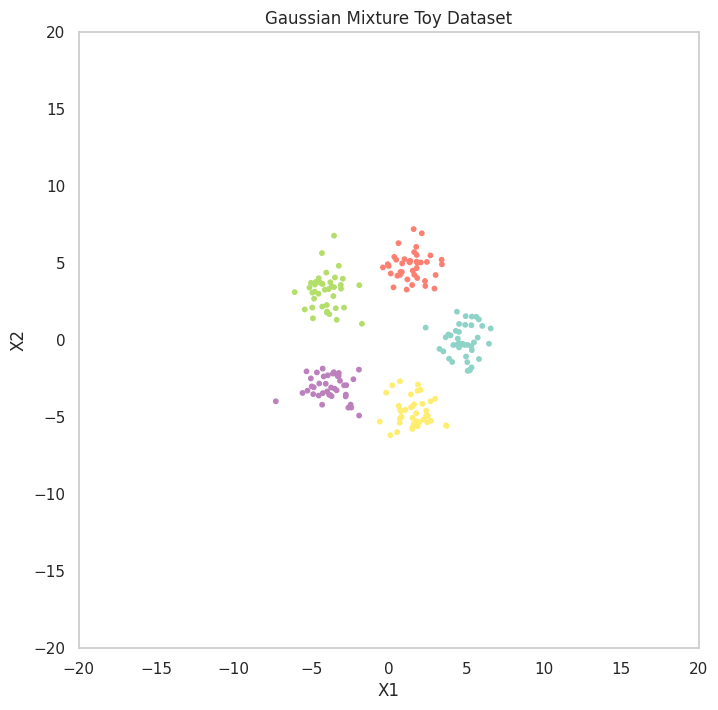

In [3]:
# visualize the dataset
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

grid_limits = (-20, 20)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.scatter(
    dataset.data[:, 0],
    dataset.data[:, 1],
    c=dataset.targets,
    s=10,
    cmap=sns.color_palette("Set3", as_cmap=True),
)

plt.title("Gaussian Mixture Toy Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.xlim(*grid_limits)
plt.ylim(*grid_limits)
plt.grid()
plt.show()

In [4]:
# MLP with 2 layers and 50 hidden units
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_uncertainty.layers.batch_ensemble import BatchLinear

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class DeepEnsembleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_estimators):
        super(DeepEnsembleMLP, self).__init__()
        self.num_estimators = num_estimators
        self.models = nn.ModuleList([MLP(input_dim, hidden_dim, output_dim) for _ in range(num_estimators)])

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        outputs = torch.stack(outputs)  # shape (num_estimators, batch_size, output_dim)
        return outputs.view(x.shape[0] * self.num_estimators, -1) # shape (num_estimators * batch_size, output_dim)
    

class BatchEnsembleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_estimators, rank):
        super(BatchEnsembleMLP, self).__init__()
        self.num_estimators = num_estimators
        self.fc1 = BatchLinear(input_dim, hidden_dim, num_estimators, rank)
        self.fc2 = BatchLinear(hidden_dim, output_dim, num_estimators, rank)
    
    def forward(self, x: torch.Tensor):
        repeat_shape = [self.num_estimators] + [1] * (x.dim() - 1)
        x = x.repeat(repeat_shape)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)         # shape (num_estimators * batch_size, output_dim)
        return x

In [5]:
input_dim = 2
hidden_dim = 50
output_dim = dataset_args['n_classes']

batch_size = 32
epochs = 60

num_estimators = 100
ranks = [1, 2, 3, 4]

In [6]:
# Dataloaders
import os
from torch_uncertainty.datamodules.classification.gaussian_mixture import GaussianMixtureDatamodule

datamodule = GaussianMixtureDatamodule(**dataset_args, batch_size=batch_size, root="", num_workers=os.cpu_count())
datamodule.setup()
train_loader = datamodule.train_dataloader()
val_loader = datamodule.val_dataloader()
test_loader = datamodule.test_dataloader()

In [7]:
from torch_uncertainty.transforms.batch import RepeatTarget
from functools import partial
from torch_uncertainty.losses.classification import RepulsiveCrossEntropyLoss

optimizer_factory = partial(torch.optim.Adam, lr=1e-3)

criterions = {
    "CrossEntropy": nn.CrossEntropyLoss(),
    "RepulsiveCrossEntropy": RepulsiveCrossEntropyLoss(num_estimators=num_estimators)
}
architectures = {
    "Deep Ensemble": DeepEnsembleMLP,
    **{f"BatchEnsemble (rank {rank})": partial(BatchEnsembleMLP, rank=rank) for rank in ranks}
}

format_batch_fn = RepeatTarget(num_repeats=num_estimators)

In [ ]:
from utils import train

loaded_models = {}

for loss_name, loss_fn in criterions.items():
    loaded_models[loss_name] = {}
    for name, architecture in architectures.items():
        print(f"Training {name} with {loss_name} loss...")

        args = {
            "input_dim": input_dim,
            "hidden_dim": hidden_dim,
            "output_dim": output_dim,
            "num_estimators": num_estimators
        }

        model = architecture(**args)
        optimizer = optimizer_factory(model.parameters())

        train(model, loss_fn, optimizer, epochs, train_loader, val_loader, format_batch_fn)
        loaded_models[loss_name][name] = model
        print()

Training Deep Ensemble with CrossEntropy loss...


Training: 100%|██████████| 60/60 [00:09<00:00,  6.37epoch/s, val_acc=100.00%, val_loss=0.0580]



Training BatchEnsemble (rank 1) with CrossEntropy loss...


Training: 100%|██████████| 60/60 [00:02<00:00, 25.04epoch/s, val_acc=99.53%, val_loss=0.0661]



Training BatchEnsemble (rank 2) with CrossEntropy loss...


Training: 100%|██████████| 60/60 [00:02<00:00, 21.83epoch/s, val_acc=99.55%, val_loss=0.0388]



Training BatchEnsemble (rank 3) with CrossEntropy loss...


Training: 100%|██████████| 60/60 [00:03<00:00, 15.86epoch/s, val_acc=98.85%, val_loss=0.0512]



Training BatchEnsemble (rank 4) with CrossEntropy loss...


Training: 100%|██████████| 60/60 [00:02<00:00, 20.45epoch/s, val_acc=98.92%, val_loss=0.0618]



Training Deep Ensemble with RepulsiveCrossEntropy loss...


Training: 100%|██████████| 60/60 [00:14<00:00,  4.26epoch/s, val_acc=87.97%, val_loss=0.4184]



Training BatchEnsemble (rank 1) with RepulsiveCrossEntropy loss...


Training: 100%|██████████| 60/60 [00:03<00:00, 16.68epoch/s, val_acc=90.38%, val_loss=0.3486]



Training BatchEnsemble (rank 2) with RepulsiveCrossEntropy loss...


Training: 100%|██████████| 60/60 [00:03<00:00, 17.19epoch/s, val_acc=94.17%, val_loss=0.1885]



Training BatchEnsemble (rank 3) with RepulsiveCrossEntropy loss...


Training: 100%|██████████| 60/60 [00:03<00:00, 18.20epoch/s, val_acc=95.33%, val_loss=0.1475]



Training BatchEnsemble (rank 4) with RepulsiveCrossEntropy loss...


Training: 100%|██████████| 60/60 [00:03<00:00, 16.53epoch/s, val_acc=94.92%, val_loss=0.1843]

In [ ]:
# use torch utils to save all models
import torch
import os
from datetime import datetime

def save_models(models, path):
    if not os.path.exists(path):
        os.makedirs(path)

    for loss_name, model_dict in models.items():
        for model_name, model in model_dict.items():
            model_path = os.path.join(path, f"{loss_name}_{model_name}.pt")
            torch.save(model.state_dict(), model_path)
            print(f"Saved {model_name} with {loss_name} loss to {model_path}")

save_path = os.path.join("pretrained", datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
save_models(loaded_models, save_path)

Saved Deep Ensemble with CrossEntropy loss to models/gaussian_mixture/2025-05-08_11-19-07/CrossEntropy_Deep Ensemble.pt
Saved BatchEnsemble (rank 1) with CrossEntropy loss to models/gaussian_mixture/2025-05-08_11-19-07/CrossEntropy_BatchEnsemble (rank 1).pt
Saved BatchEnsemble (rank 2) with CrossEntropy loss to models/gaussian_mixture/2025-05-08_11-19-07/CrossEntropy_BatchEnsemble (rank 2).pt
Saved BatchEnsemble (rank 3) with CrossEntropy loss to models/gaussian_mixture/2025-05-08_11-19-07/CrossEntropy_BatchEnsemble (rank 3).pt
Saved BatchEnsemble (rank 4) with CrossEntropy loss to models/gaussian_mixture/2025-05-08_11-19-07/CrossEntropy_BatchEnsemble (rank 4).pt
Saved Deep Ensemble with RepulsiveCrossEntropy loss to models/gaussian_mixture/2025-05-08_11-19-07/RepulsiveCrossEntropy_Deep Ensemble.pt
Saved BatchEnsemble (rank 1) with RepulsiveCrossEntropy loss to models/gaussian_mixture/2025-05-08_11-19-07/RepulsiveCrossEntropy_BatchEnsemble (rank 1).pt
Saved BatchEnsemble (rank 2) with 

In [8]:
# load models
def load_models(path):
    models = {}
    for file_name in os.listdir(path):
        if file_name.endswith(".pt"):
            model_path = os.path.join(path, file_name)
            loss_name, model_name = file_name.split("_")[:2]
            # remove .pt ending from model name
            model_name = model_name.replace(".pt", "")
            # instantiate model based on name and rank in the save name
            if "BatchEnsemble" in model_name:
                rank = int(model_name.split("rank ")[-1].split(")")[0])
                model = BatchEnsembleMLP(input_dim, hidden_dim, output_dim, num_estimators, rank)
            else:
                model = DeepEnsembleMLP(input_dim, hidden_dim, output_dim, num_estimators)
            model.load_state_dict(torch.load(model_path))
            # dict for each loss
            if loss_name not in models:
                models[loss_name] = {}
            models[loss_name][model_name] = model
    return models

save_path = "pretrained/2025-05-08_11-19-07"
loaded_models = load_models(save_path)

# print to check
for loss_name, model_dict in loaded_models.items():
    print(f"Loss: {loss_name}")
    for model_name, model in model_dict.items():
        print(f"  Model: {model_name}")
        print(f"    Parameters: {sum(p.numel() for p in model.parameters())}")
        print(f"    Model: {model}")

Loss: CrossEntropy
  Model: BatchEnsemble (rank 3)
    Parameters: 37950
    Model: BatchEnsembleMLP(
  (fc1): BatchLinear(
    in_features=2, out_features=50, num_estimators=100, rank=3, bias=True,
    (linear): Linear(in_features=2, out_features=50, bias=False)
  )
  (fc2): BatchLinear(
    in_features=50, out_features=5, num_estimators=100, rank=3, bias=True,
    (linear): Linear(in_features=50, out_features=5, bias=False)
  )
)
  Model: BatchEnsemble (rank 4)
    Parameters: 48650
    Model: BatchEnsembleMLP(
  (fc1): BatchLinear(
    in_features=2, out_features=50, num_estimators=100, rank=4, bias=True,
    (linear): Linear(in_features=2, out_features=50, bias=False)
  )
  (fc2): BatchLinear(
    in_features=50, out_features=5, num_estimators=100, rank=4, bias=True,
    (linear): Linear(in_features=50, out_features=5, bias=False)
  )
)
  Model: BatchEnsemble (rank 1)
    Parameters: 16550
    Model: BatchEnsembleMLP(
  (fc1): BatchLinear(
    in_features=2, out_features=50, num_es

In [9]:
# sort models by name Batch Ensemble (rank 1) -> Batch Ensemble (rank 2) -> Batch Ensemble (rank 3) -> Batch Ensemble (rank 4) -> Deep Ensemble
def sort_models(models):
    sorted_models = {}
    for loss_name, model_dict in models.items():
        sorted_models[loss_name] = {}
        # sort by rank
        sorted_model_names = sorted(model_dict.keys(), key=lambda x: (x.split("rank ")[-1], x))
        for model_name in sorted_model_names:
            sorted_models[loss_name][model_name] = model_dict[model_name]
    return sorted_models

sorted_models = sort_models(loaded_models)

# print to check
for loss_name, model_dict in sorted_models.items():
    print(f"Loss: {loss_name}")
    for model_name, model in model_dict.items():
        print(f"  Model: {model_name}")

Loss: CrossEntropy
  Model: BatchEnsemble (rank 1)
  Model: BatchEnsemble (rank 2)
  Model: BatchEnsemble (rank 3)
  Model: BatchEnsemble (rank 4)
  Model: Deep Ensemble
Loss: RepulsiveCrossEntropy
  Model: BatchEnsemble (rank 1)
  Model: BatchEnsemble (rank 2)
  Model: BatchEnsemble (rank 3)
  Model: BatchEnsemble (rank 4)
  Model: Deep Ensemble


In [86]:
from utils import model_uncertainty_surface

uncertainy_surface_dict = {}
for loss_name, model_dict in sorted_models.items():
    uncertainy_surface_dict[loss_name] = {}
    for model_name, model in model_dict.items():
        print(f"Computing uncertainty surface for {model_name} with {loss_name} loss...")
        uncertainy_surface_dict[loss_name][model_name] = model_uncertainty_surface(
            model, 
            grid_limits, 
            criterion="disagreement",)

Computing uncertainty surface for BatchEnsemble (rank 1) with CrossEntropy loss...
Computing uncertainty surface for BatchEnsemble (rank 2) with CrossEntropy loss...
Computing uncertainty surface for BatchEnsemble (rank 3) with CrossEntropy loss...
Computing uncertainty surface for BatchEnsemble (rank 4) with CrossEntropy loss...
Computing uncertainty surface for Deep Ensemble with CrossEntropy loss...
Computing uncertainty surface for BatchEnsemble (rank 1) with RepulsiveCrossEntropy loss...
Computing uncertainty surface for BatchEnsemble (rank 2) with RepulsiveCrossEntropy loss...
Computing uncertainty surface for BatchEnsemble (rank 3) with RepulsiveCrossEntropy loss...
Computing uncertainty surface for BatchEnsemble (rank 4) with RepulsiveCrossEntropy loss...
Computing uncertainty surface for Deep Ensemble with RepulsiveCrossEntropy loss...


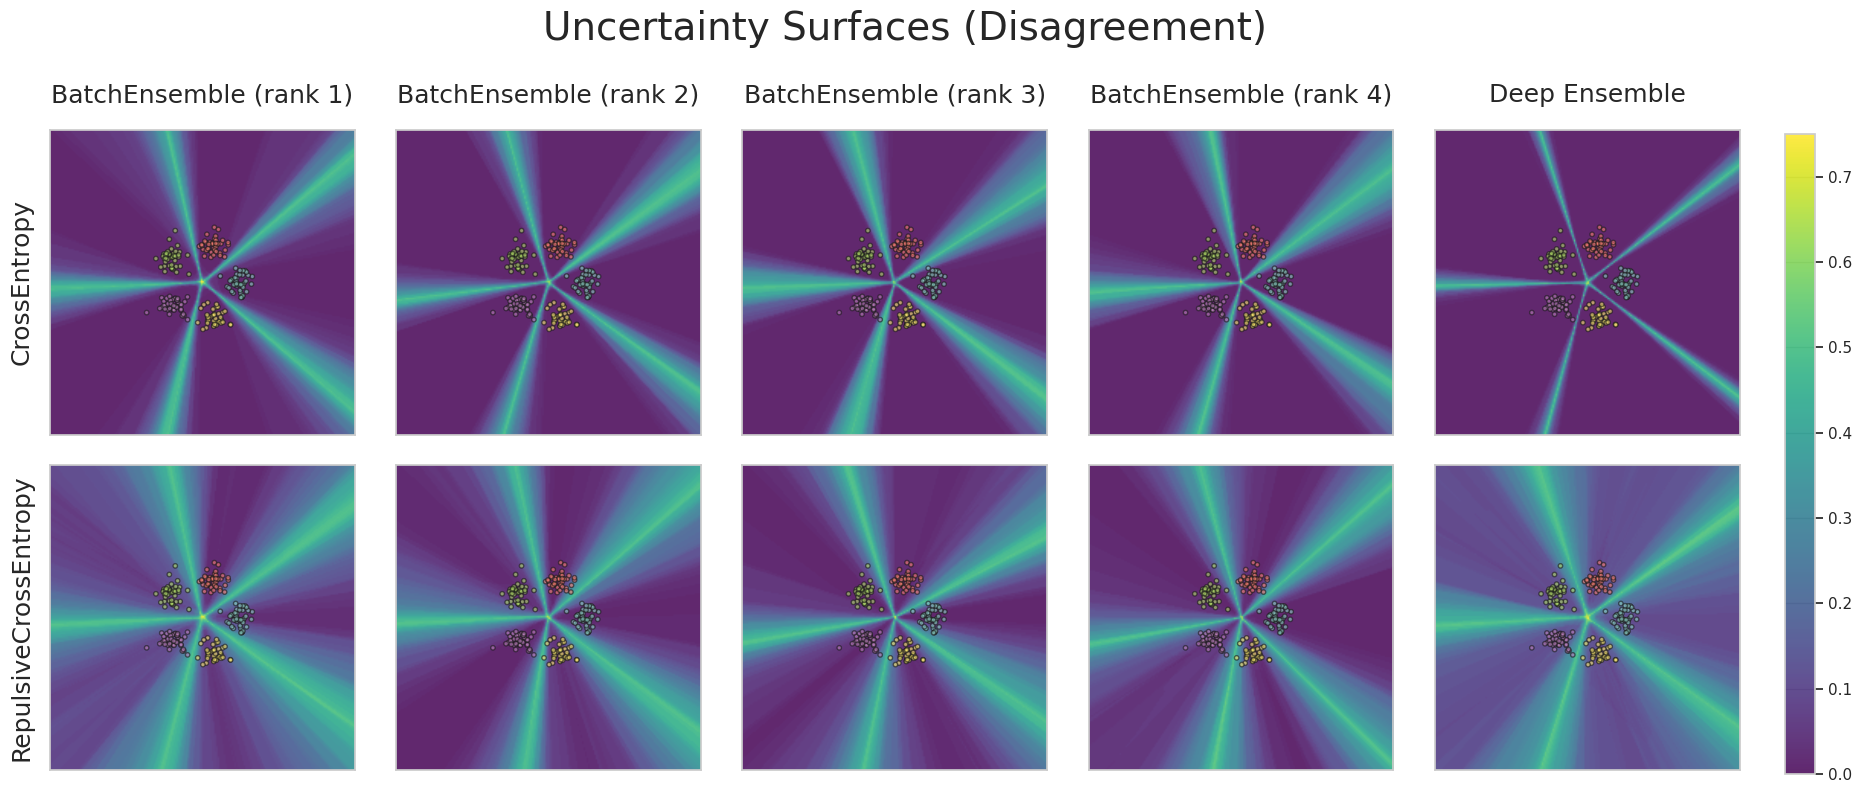

In [ ]:
from utils import plot_uncertainty_surfaces

save_path = "uncertainty_surfaces_disagreement"
# loss as row names and models as column names
loss_names = list(sorted_models.keys())
model_names = list(sorted_models[loss_names[0]].keys())
uncertainty_surface_grid = [
    [uncertainy_surface_dict[loss_name][model_name] for model_name in model_names]
    for loss_name in loss_names
]

# plot the model grid
plot_uncertainty_surfaces(
    uncertainty_surface_grid,
    row_names=loss_names,
    col_names=model_names,
    dataset=dataset,
    criterion="disagreement",
    grid_limits=grid_limits,
    save_path=save_path,
)

In [60]:
# predict example (20, -20) with BatchEnsemble (rank 4) and CrossEntropy loss
model = sorted_models["CrossEntropy"]["BatchEnsemble (rank 4)"]
model.eval()
x = torch.tensor([[20, -20]], dtype=torch.float32)
with torch.no_grad():
    output = model(x)
    # reshape to (num_estimators, batch_size, output_dim)
    output = output.view(num_estimators, -1, output_dim)
    # get mean and std
    mean = output.mean(dim=0)
    std = output.std(dim=0)
    # get predicted class
    pred = mean.argmax(dim=1)
    # get predicted class probabilities
    probs = mean.softmax(dim=1)
    # entropy
    entropy = -torch.sum(probs * probs.log(), dim=1)

print(f"Mean: {mean}")
print(f"Std: {std}")
print(f"Predicted class: {pred.item()}")
print(f"Predicted class probabilities: {probs}")
print(f"Entropy: {entropy}")


Mean: tensor([[ 101.0980,  -25.0350, -258.5875,  -51.0983,  129.6314]])
Std: tensor([[38.7586, 32.4198, 87.9309, 46.1214, 47.4141]])
Predicted class: 4
Predicted class probabilities: tensor([[4.0560e-13, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]])
Entropy: tensor([nan])


In [61]:
# Predict example (20, -20) with BatchEnsemble (rank 4) and CrossEntropy loss
model = sorted_models["CrossEntropy"]["BatchEnsemble (rank 4)"]
model.eval()
x = torch.tensor([[20, -20]], dtype=torch.float32)
with torch.no_grad():
    output = model(x)
    # Reshape to (num_estimators, batch_size, output_dim)
    output = output.view(num_estimators, -1, output_dim)
    # Get mean and std
    mean = output.mean(dim=0)
    std = output.std(dim=0)

    # Handle invalid values in mean
    mean = torch.nan_to_num(mean, nan=0.0, posinf=0.0, neginf=0.0)

    # Get predicted class probabilities
    probs = mean.softmax(dim=1)

    # Clamp probabilities to avoid log(0)
    probs = probs.clamp(min=1e-9)

    # Entropy
    entropy = -torch.sum(probs * probs.log(), dim=1)

    # Get predicted class
    pred = mean.argmax(dim=1)

print(f"Mean: {mean}")
print(f"Std: {std}")
print(f"Predicted class: {pred.item()}")
print(f"Predicted class probabilities: {probs}")
print(f"Entropy: {entropy}")

Mean: tensor([[ 101.0980,  -25.0350, -258.5875,  -51.0983,  129.6314]])
Std: tensor([[38.7586, 32.4198, 87.9309, 46.1214, 47.4141]])
Predicted class: 4
Predicted class probabilities: tensor([[1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e+00]])
Entropy: tensor([8.2893e-08])
